In [ ]:
# import zipfile

# with zipfile.ZipFile("P3M-10k.zip", "r") as zip_ref:
#     zip_ref.extractall("P3M-10k")


In [1]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm

In [2]:
torch.__version__

'2.4.1+cu124'

In [14]:
# Define paths in a dictionary
paths = {
    "train_img": "P3M-10k/P3M-10k/train/mask/blurred_image",
    "train_mask": "P3M-10k/P3M-10k/train/mask",
    "train_list": "P3M-10k/P3M-10k/train_list.txt",
    "val_img": "P3M-10k/P3M-10k/validation/P3M-500-NP/original_image",
    "val_mask": "P3M-10k/P3M-10k/validation/P3M-500-NP/mask",
    "val_list": "P3M-10k/P3M-10k/P3M-500-NP_list.txt"
}



In [4]:
device = "cuda:4" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cuda:4


In [31]:
BATCH_SIZE = 16
EPOCHS = 20
NUM_CLASS = 1 # Subject , Background

lr = 3e-3
weight_decay = 1e-4

In [15]:
# from torch.utils.data import Dataset
# from torchvision import transforms

class CityscapeDataset(Dataset):
    def __init__(self, img_dir, mask_dir, list_file, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        with open(list_file, 'r') as file:
            self.img_mask_list = file.read().splitlines()
        self.extensions = ['.png', '.jpg', '.jpeg']

    def __len__(self):
        return len(self.img_mask_list)

    def __getitem__(self, idx):
        img_name = self.img_mask_list[idx]
        img_path = self.find_file_with_extension(self.img_dir, img_name)
        mask_path = self.find_file_with_extension(self.mask_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        return image, mask

    def find_file_with_extension(self, directory, filename):
        for ext in self.extensions:
            file_path = os.path.join(directory, filename + ext)
            if os.path.exists(file_path):
                return file_path
        raise FileNotFoundError(f"File {filename} with supported extensions not found in {directory}")

# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Create datasets using the paths from the dictionary
train_dataset = CityscapeDataset(paths["train_img"], paths["train_mask"], paths["train_list"], transform=transform)
val_dataset = CityscapeDataset(paths["val_img"], paths["val_mask"], paths["val_list"], transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [16]:
# Display information about the datasets and loaders
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")

# Check image and mask shapes for one sample
sample_img, sample_mask = next(iter(train_loader))
print(f"Input shape: {sample_img.shape}")
print(f"Mask shape: {sample_mask.shape}")

# Calculate some statistics on the sample
print(f"Image min: {sample_img.min():.4f}, max: {sample_img.max():.4f}, mean: {sample_img.mean():.4f}")
print(f"Mask min: {sample_mask.min():.4f}, max: {sample_mask.max():.4f}, mean: {sample_mask.mean():.4f}")
print(f"Mask ratio: {sample_mask.mean():.4f} (proportion of foreground pixels)")

Number of training samples: 9421
Number of validation samples: 500
Number of training batches: 589
Number of validation batches: 32
Input shape: torch.Size([16, 3, 256, 256])
Mask shape: torch.Size([16, 1, 256, 256])
Image min: 0.0000, max: 1.0000, mean: 0.4842
Mask min: 0.0000, max: 1.0000, mean: 0.3619
Mask ratio: 0.3619 (proportion of foreground pixels)


In [9]:
! pwd

/workspace/saumilya/Unet


In [17]:
for images, masks in train_loader:
    print(images.shape, masks.shape)
    break  # Remove this line if you want to iterate through the entire loader

torch.Size([16, 3, 256, 256]) torch.Size([16, 1, 256, 256])


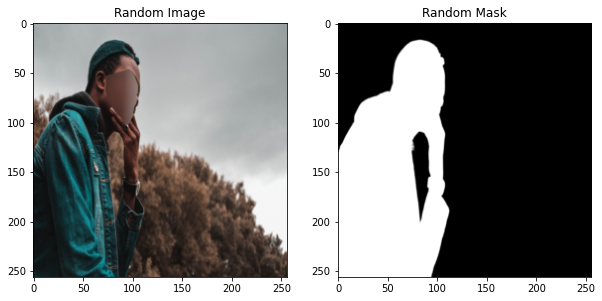

In [30]:
import random

# Get a random index
random_idx = random.randint(0, len(train_dataset) - 1)

# Get the image and mask at the random index
random_image, random_mask = train_dataset[random_idx]

# Convert the image and mask to numpy arrays for plotting
random_image_np = random_image.numpy().transpose(1, 2, 0)
random_mask_np = random_mask.numpy().squeeze()

# Plot the random image and mask
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(random_image_np)
ax[0].set_title('Random Image')
ax[1].imshow(random_mask_np, cmap='gray')
ax[1].set_title('Random Mask')
plt.show()

In [32]:
class UNet(nn.Module):
    
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=512, out_channels=256)
        self.expansive_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=256, out_channels=128)
        self.expansive_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_42 = self.conv_block(in_channels=128, out_channels=64)
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)
        
    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block
    
    def forward(self, X):
        contracting_11_out = self.contracting_11(X) # [-1, 64, 256, 256]
        contracting_12_out = self.contracting_12(contracting_11_out) # [-1, 64, 128, 128]
        contracting_21_out = self.contracting_21(contracting_12_out) # [-1, 128, 128, 128]
        contracting_22_out = self.contracting_22(contracting_21_out) # [-1, 128, 64, 64]
        contracting_31_out = self.contracting_31(contracting_22_out) # [-1, 256, 64, 64]
        contracting_32_out = self.contracting_32(contracting_31_out) # [-1, 256, 32, 32]
        contracting_41_out = self.contracting_41(contracting_32_out) # [-1, 512, 32, 32]
        contracting_42_out = self.contracting_42(contracting_41_out) # [-1, 512, 16, 16]
        middle_out = self.middle(contracting_42_out) # [-1, 1024, 16, 16]
        expansive_11_out = self.expansive_11(middle_out) # [-1, 512, 32, 32]
        expansive_12_out = self.expansive_12(torch.cat((expansive_11_out, contracting_41_out), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        expansive_21_out = self.expansive_21(expansive_12_out) # [-1, 256, 64, 64]
        expansive_22_out = self.expansive_22(torch.cat((expansive_21_out, contracting_31_out), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        expansive_31_out = self.expansive_31(expansive_22_out) # [-1, 128, 128, 128]
        expansive_32_out = self.expansive_32(torch.cat((expansive_31_out, contracting_21_out), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        expansive_41_out = self.expansive_41(expansive_32_out) # [-1, 64, 256, 256]
        expansive_42_out = self.expansive_42(torch.cat((expansive_41_out, contracting_11_out), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        output_out = self.output(expansive_42_out) # [-1, num_classes, 256, 256]
        return output_out

In [33]:
model = UNet(num_classes=NUM_CLASS).to(device)

In [35]:
import os

# Load trained model weights if they exist

model_path = "unet.pth"
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path, map_location=device))
    print(f"Loaded model weights from {model_path}")
else:
    print(f"No pre-trained weights found at {model_path}. Using randomly initialized weights.")

Loaded model weights from unet.pth


<ipython-input-35-42b68a1a94ac>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


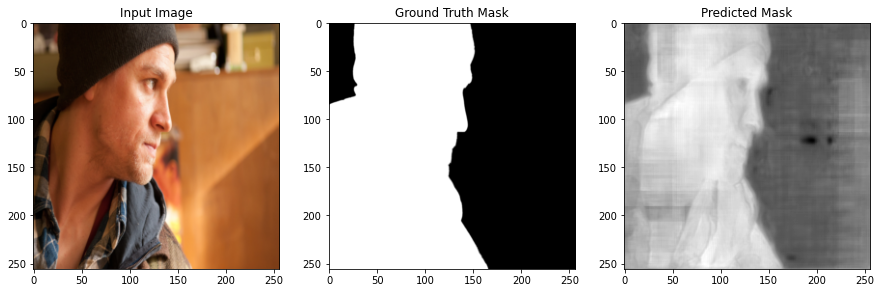

In [37]:
# Get one sample from the validation dataset
sample_image, sample_mask = val_dataset[0]
sample_image = sample_image.unsqueeze(0).to(device)  # Add batch dimension and move to device

# Pass the sample through the model
model.eval()
with torch.no_grad():
    output = model(sample_image)

# Convert the output to a numpy array and plot the result
output = output.squeeze().cpu().numpy()
sample_image = sample_image.squeeze().cpu().numpy().transpose(1, 2, 0)
sample_mask = sample_mask.squeeze().cpu().numpy()

# Plot the input image, ground truth mask, and predicted mask
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(sample_image)
ax[0].set_title('Input Image')
ax[1].imshow(sample_mask, cmap='gray')
ax[1].set_title('Ground Truth Mask')
ax[2].imshow(output, cmap='gray')
ax[2].set_title('Predicted Mask')
plt.show()

In [13]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
# criterion = nn.CrossEntropyLoss()
criterion = nn.BCEWithLogitsLoss()


In [38]:
# criterion = nn.CrossEntropyLoss()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [ ]:
# criterion = nn.BCEWithLogitsLoss()  # Output shape: [batch, 1, H, W]
# loss = criterion(outputs.squeeze(1), masks.float())  # Convert masks to float


In [ ]:
from tqdm import tqdm
import torch

# Initialize lists to store training and validation metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Initialize learning rate scheduler
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Training loop
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")  # Print epoch number

    model.train()
    train_loss = 0
    correct_train = 0
    total_train = 0

    train_bar = tqdm(train_loader, desc="Training Batches", leave=True)  # Show batch progress

    for images, masks in train_bar:
        images, masks = images.to(device), masks.to(device).float()  # Convert masks to float
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs.squeeze(1), masks.squeeze(1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        # Calculate training accuracy
        predicted = (outputs > 0.5).float()
        total_train += masks.nelement()
        correct_train += (predicted == masks).sum().item()
        
        # Update progress bar with loss and accuracy
        train_bar.set_postfix(loss=loss.item(), acc=100 * correct_train / total_train)

    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(100 * correct_train / total_train)
    
    # Validation
    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0

    val_bar = tqdm(val_loader, desc="Validation Batches", leave=True)  # Show batch progress

    with torch.no_grad():
        for images, masks in val_bar:
            images, masks = images.to(device), masks.to(device).float()  # Convert masks to float
            outputs = model(images)
            loss = criterion(outputs.squeeze(1), masks.squeeze(1))
            val_loss += loss.item()
            
            # Calculate validation accuracy
            predicted = (outputs > 0.5).float()
            total_val += masks.nelement()
            correct_val += (predicted == masks).sum().item()
            
            # Update progress bar with loss and accuracy
            val_bar.set_postfix(loss=loss.item(), acc=100 * correct_val / total_val)

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(100 * correct_val / total_val)
    
    print(f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.2f}%\n")

    # Step the learning rate scheduler
    lr_scheduler.step()

torch.save(model.state_dict(), "unet.pth")


Epoch 1/20


Validation Batches: 100%|██████████| 32/32 [00:28<00:00,  1.13it/s, acc=92.7, loss=0.0573]


Train Loss: 0.0569, Train Acc: 95.27%, Val Loss: 0.1010, Val Acc: 92.66%

Epoch 2/20


Validation Batches: 100%|██████████| 32/32 [00:26<00:00,  1.19it/s, acc=93.2, loss=0.0459]


Train Loss: 0.0471, Train Acc: 95.61%, Val Loss: 0.0964, Val Acc: 93.25%

Epoch 3/20


Validation Batches: 100%|██████████| 32/32 [00:26<00:00,  1.20it/s, acc=92.9, loss=0.0511]


Train Loss: 0.0404, Train Acc: 95.85%, Val Loss: 0.0994, Val Acc: 92.86%

Epoch 4/20


Validation Batches: 100%|██████████| 32/32 [00:27<00:00,  1.16it/s, acc=92.5, loss=0.0987]


Train Loss: 0.0395, Train Acc: 95.88%, Val Loss: 0.1156, Val Acc: 92.49%

Epoch 5/20


Validation Batches: 100%|██████████| 32/32 [00:27<00:00,  1.17it/s, acc=93.4, loss=0.0432]


Train Loss: 0.0332, Train Acc: 96.11%, Val Loss: 0.0926, Val Acc: 93.39%

Epoch 6/20


Validation Batches: 100%|██████████| 32/32 [00:27<00:00,  1.16it/s, acc=94.2, loss=0.0445]


Train Loss: 0.0213, Train Acc: 96.48%, Val Loss: 0.0809, Val Acc: 94.23%

Epoch 7/20


Validation Batches: 100%|██████████| 32/32 [00:27<00:00,  1.17it/s, acc=94.3, loss=0.0448]


Train Loss: 0.0179, Train Acc: 96.58%, Val Loss: 0.0920, Val Acc: 94.26%

Epoch 8/20


Validation Batches: 100%|██████████| 32/32 [00:27<00:00,  1.17it/s, acc=94.2, loss=0.0444]


Train Loss: 0.0171, Train Acc: 96.60%, Val Loss: 0.0929, Val Acc: 94.23%

Epoch 9/20


Validation Batches: 100%|██████████| 32/32 [00:27<00:00,  1.18it/s, acc=94.2, loss=0.0319]


Train Loss: 0.0172, Train Acc: 96.59%, Val Loss: 0.0936, Val Acc: 94.24%

Epoch 10/20


Validation Batches: 100%|██████████| 32/32 [00:27<00:00,  1.18it/s, acc=89.6, loss=0.173] 


Train Loss: 0.0194, Train Acc: 96.53%, Val Loss: 0.1993, Val Acc: 89.60%

Epoch 11/20


Validation Batches: 100%|██████████| 32/32 [00:27<00:00,  1.15it/s, acc=94.2, loss=0.0383]


Train Loss: 0.0190, Train Acc: 96.54%, Val Loss: 0.0927, Val Acc: 94.20%

Epoch 12/20


Validation Batches: 100%|██████████| 32/32 [00:31<00:00,  1.02it/s, acc=94.2, loss=0.0472]


Train Loss: 0.0158, Train Acc: 96.63%, Val Loss: 0.0989, Val Acc: 94.24%

Epoch 13/20


Training Batches:  18%|█▊        | 108/589 [02:05<09:16,  1.16s/it, acc=96.6, loss=0.019] 

In [ ]:
# Get one sample from the validation dataset
sample_image, sample_mask = val_dataset[0]
sample_image = sample_image.unsqueeze(0).to(device)  # Add batch dimension and move to device

# Pass the sample through the model
model.eval()
with torch.no_grad():
    output = model(sample_image)

print("Shape of Model OP",output.shape)
# print(output)   
# Convert the output to a numpy array and plot the result
output = output.squeeze().cpu().numpy()
print("Shape of Model OP in numpy",output.shape)

output = (outputs > 0.5).float().cpu().numpy()
print("Shape of Model OP in after th",output.shape)

sample_image = sample_image.squeeze().cpu().numpy().transpose(1, 2, 0)
sample_mask = sample_mask.squeeze().cpu().numpy()
# print(sample_mask)

# Plot the input image, ground truth mask, and predicted mask
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(sample_image)
ax[0].set_title('Input Image')
ax[1].imshow(sample_mask, cmap='gray')
ax[1].set_title('Ground Truth Mask')
ax[2].imshow(output, cmap='gray')
ax[2].set_title('Predicted Mask')
plt.show()

Shape of Model OP torch.Size([1, 1, 256, 256])
Shape of Model OP in numpy (256, 256)
Shape of Model OP after thresholding (256, 256)


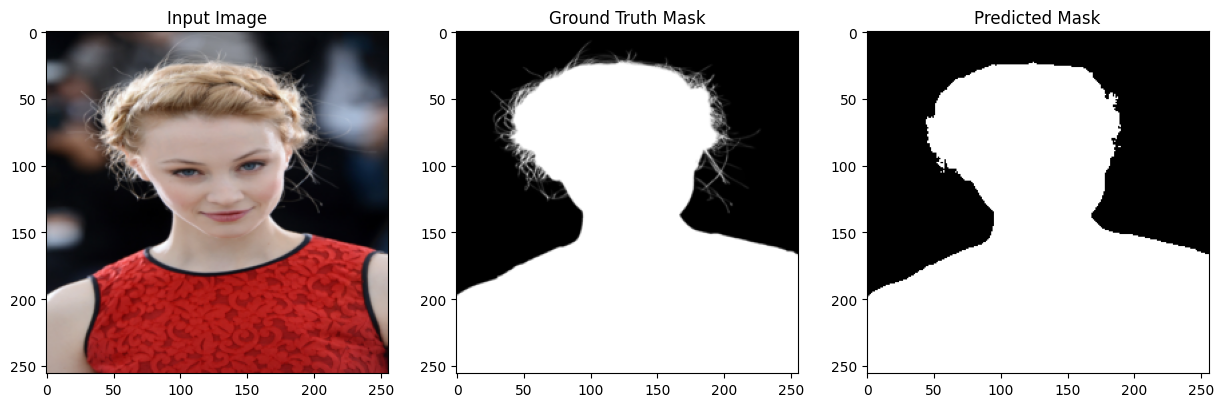

In [86]:
# Get one sample from the validation dataset
sample_image, sample_mask = val_dataset[18]
sample_image = sample_image.unsqueeze(0).to(device)  # Add batch dimension and move to device

# Pass the sample through the model
model.eval()
with torch.no_grad():
    output = model(sample_image)

print("Shape of Model OP", output.shape)  # Expected: [1, 1, 256, 256]

# Convert the output to numpy and process it
output = output.squeeze().cpu().numpy()  # Remove batch & channel dimensions
print("Shape of Model OP in numpy", output.shape)  # Expected: (256, 256)

# Apply thresholding correctly
output = (output > 0.5).astype(np.float32)  # Ensure proper boolean masking
print("Shape of Model OP after thresholding", output.shape)  # Expected: (256, 256)

# Convert input image and mask to numpy
sample_image = sample_image.squeeze().cpu().numpy().transpose(1, 2, 0)
sample_mask = sample_mask.squeeze().cpu().numpy()

# Plot the input image, ground truth mask, and predicted mask
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(sample_image)
ax[0].set_title('Input Image')
ax[1].imshow(sample_mask, cmap='gray')
ax[1].set_title('Ground Truth Mask')
ax[2].imshow(output, cmap='gray')
ax[2].set_title('Predicted Mask')
plt.show()


In [75]:
output.flatten().shape

(65536,)

In [76]:
output = (outputs > 0.5)
output.flatten().float().cpu().shape

torch.Size([262144])